In [4]:
import xarray as xr
import numpy as np
from geopy.distance import geodesic
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def read_nc_file(file):
    ds = xr.open_dataset(file)
    pressure = ds['pressure'].values.flatten()
    temperature = ds['temperature'].values.flatten()
    salinity = ds['salinity'].values.flatten()
    latitude = ds['latitude'].values.flatten()[0]
    longitude = ds['longitude'].values.flatten()[0]
    time = ds['time'].values.flatten()[0]
    ds.close()
    return pressure, temperature, salinity, latitude, longitude, time

def process_casts(files, indices):
    casts = []
    for i in indices:
        file = files[i]
        pressure, temperature, salinity, latitude, longitude, time = read_nc_file(file)
        cast = {
            'pressure': pressure,
            'temperature': temperature,
            'salinity': salinity,
            'latitude': latitude,
            'longitude': longitude,
            'time': time
        }
        casts.append(cast)
    return casts

def calculate_distances(casts):
    base_coord = (casts[0]['latitude'], casts[0]['longitude'])
    distances = [0]  # Distance from the first included cast is 0
    for cast in casts[1:]:
        coord = (cast['latitude'], cast['longitude'])
        distance = geodesic(base_coord, coord).kilometers
        distances.append(distance)
    return distances

def create_dataset(casts, distances):
    # Determine the common pressure grid
    all_pressures = np.concatenate([cast['pressure'] for cast in casts])
    unique_pressures = np.unique(all_pressures)
    
    temp_interp = np.empty((len(casts), len(unique_pressures)))
    sal_interp = np.empty((len(casts), len(unique_pressures)))
    
    for i, cast in enumerate(casts):
        temp_interp[i] = np.interp(unique_pressures, cast['pressure'], cast['temperature'])
        sal_interp[i] = np.interp(unique_pressures, cast['pressure'], cast['salinity'])
    
    latitudes = np.array([cast['latitude'] for cast in casts])
    longitudes = np.array([cast['longitude'] for cast in casts])
    times = np.array([cast['time'] for cast in casts])
    
    # Fill values below the seafloor (maximum pressure) with NaN
    for i, cast in enumerate(casts):
        max_pressure = np.max(cast['pressure'])
        temp_interp[i][unique_pressures > max_pressure] = np.nan
        sal_interp[i][unique_pressures > max_pressure] = np.nan
    
    ds = xr.Dataset(
        {
            'temperature': (['cast', 'pressure'], temp_interp),
            'salinity': (['cast', 'pressure'], sal_interp),
            'latitude': (['cast'], latitudes),
            'longitude': (['cast'], longitudes),
            'time': (['cast'], times),
            'distance': (['cast'], distances)
        },
        coords={
            'cast': np.arange(len(casts)),
            'pressure': unique_pressures,
        }
    )
    return ds



# Directory containing the .nc files
nc_files_dir = 'Y:/in2024_v04/ctd/processing/in2024_v04/cap/cappro/avg'

# List all .nc files in the directory
nc_files = [os.path.join(nc_files_dir, file) for file in os.listdir(nc_files_dir) if file.endswith('.nc')]

# Define the indices for each transect
transect1_indices = [1, 2, 3,4]
transect2_indices = [5, 14, 13, 12]
transect3_indices = [7,6, 8, 9, 10]

transects_indices = [transect1_indices, transect2_indices, transect3_indices]

# Process each transect
transects_casts = [process_casts(nc_files, indices) for indices in transects_indices]
transects_distances = [calculate_distances(casts) for casts in transects_casts]

# Create the combined datasets for each transect
transects_datasets = [create_dataset(casts, distances) for casts, distances in zip(transects_casts, transects_distances)]




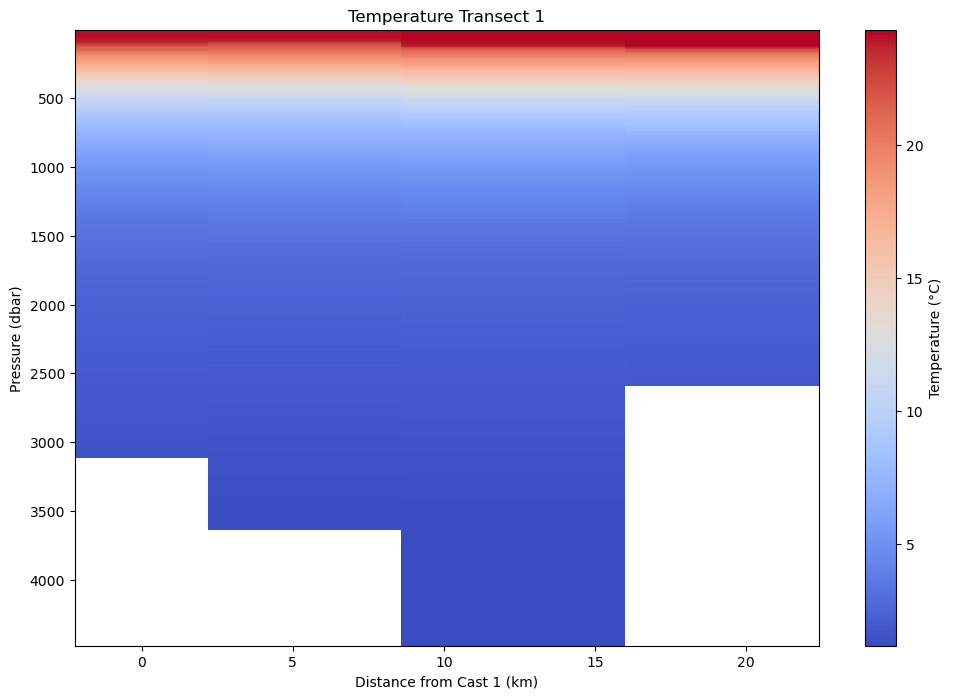

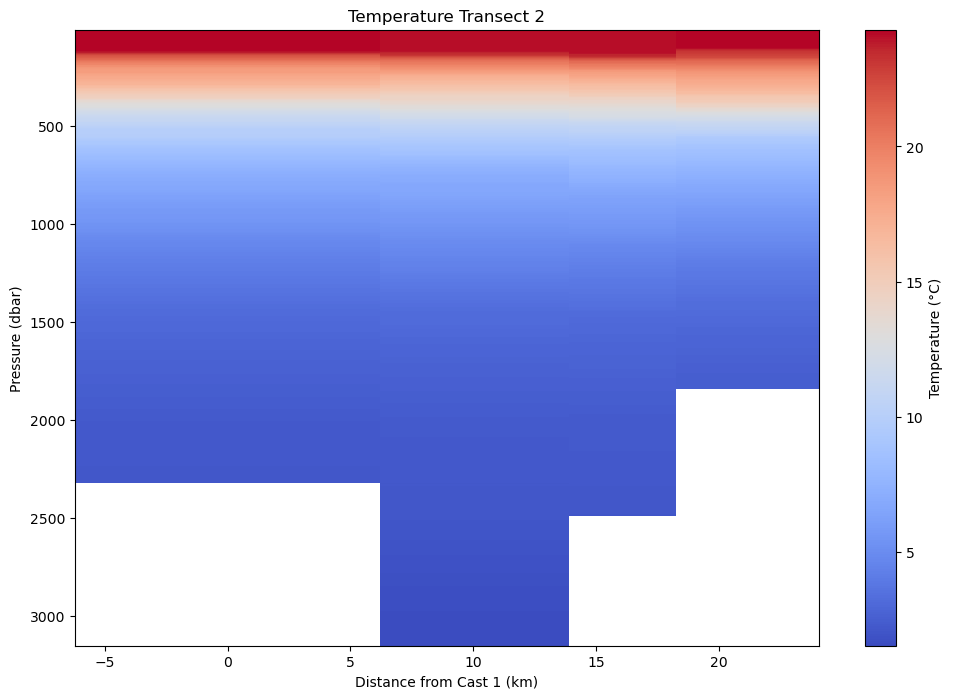

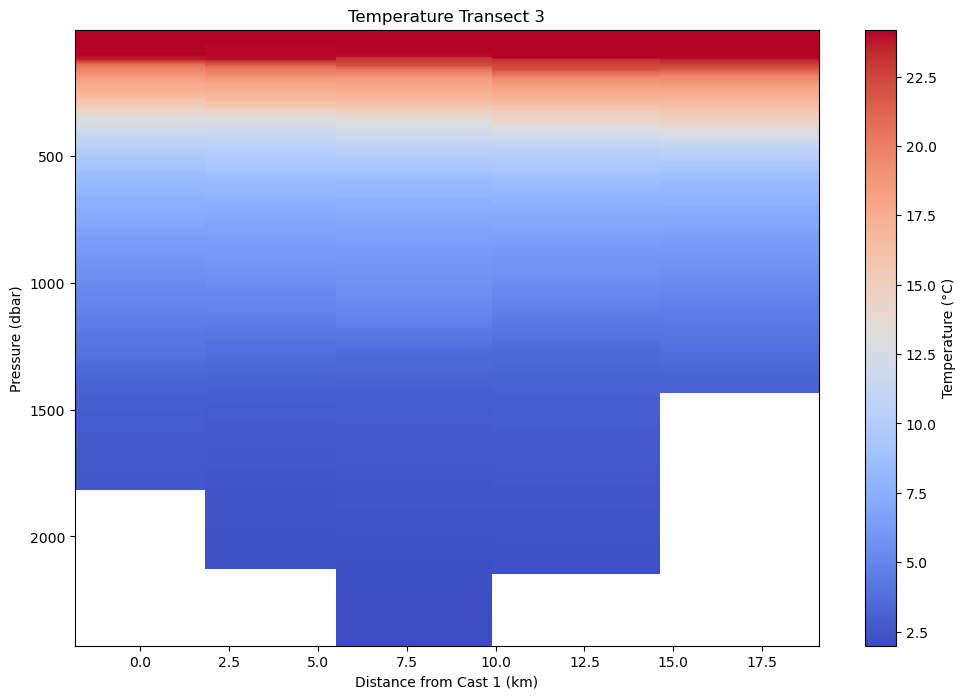

In [5]:
def plot_transect(ds, transect_number):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract the data for plotting
    distance = ds['distance'].values
    pressure = ds['pressure'].values
    temperature = ds['temperature'].values
    
    # Create the meshgrid for distance and pressure
    X, Y = np.meshgrid(distance, pressure)
    
    # Plot the temperature as a color mesh
    c = ax.pcolormesh(X, Y, temperature.T, shading='auto', cmap='coolwarm')
    
    # Add color bar
    cb = fig.colorbar(c, ax=ax)
    cb.set_label('Temperature (°C)')
    
    # Set axis labels and title
    ax.set_xlabel('Distance from Cast 1 (km)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title(f'Temperature Transect {transect_number}')
    
    # Reverse the y-axis to have pressure increasing downwards
    ax.invert_yaxis()
    
    plt.show()

# Plot the transects
for i, ds in enumerate(transects_datasets):
    plot_transect(ds, i + 1)

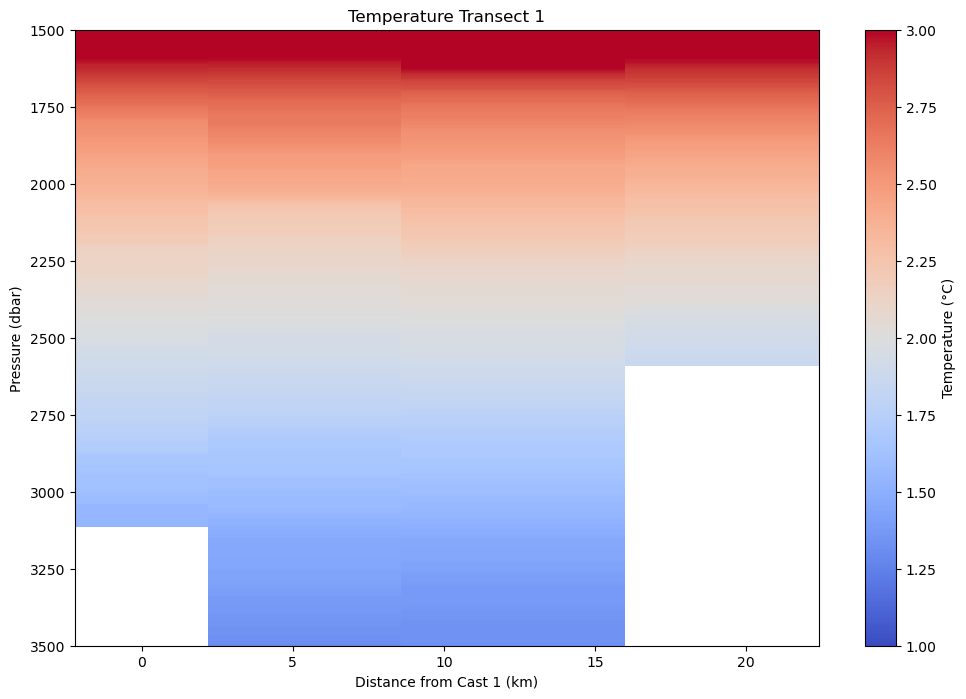

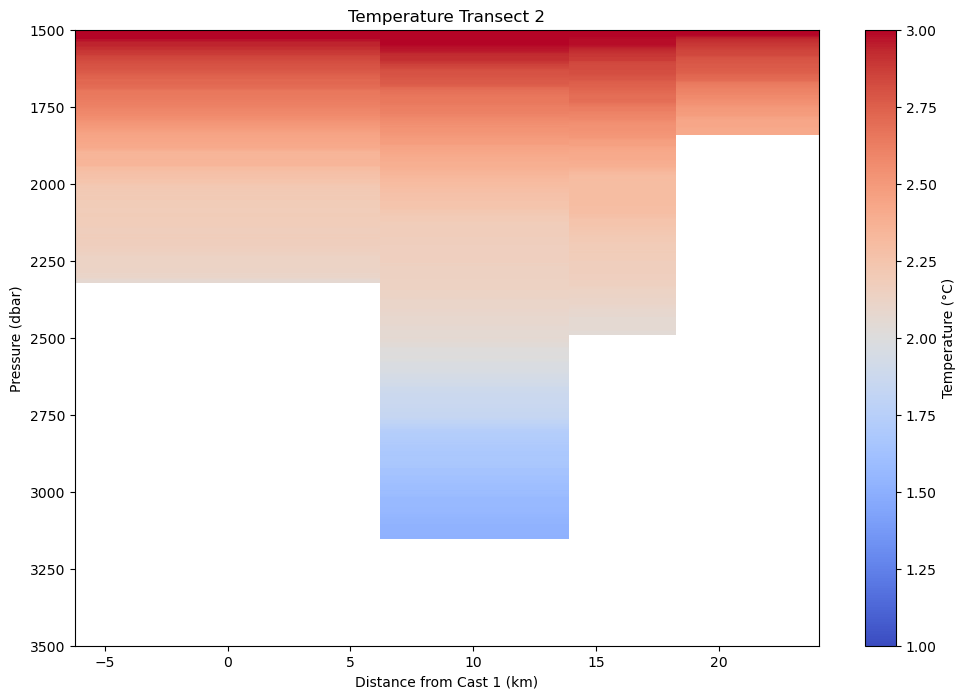

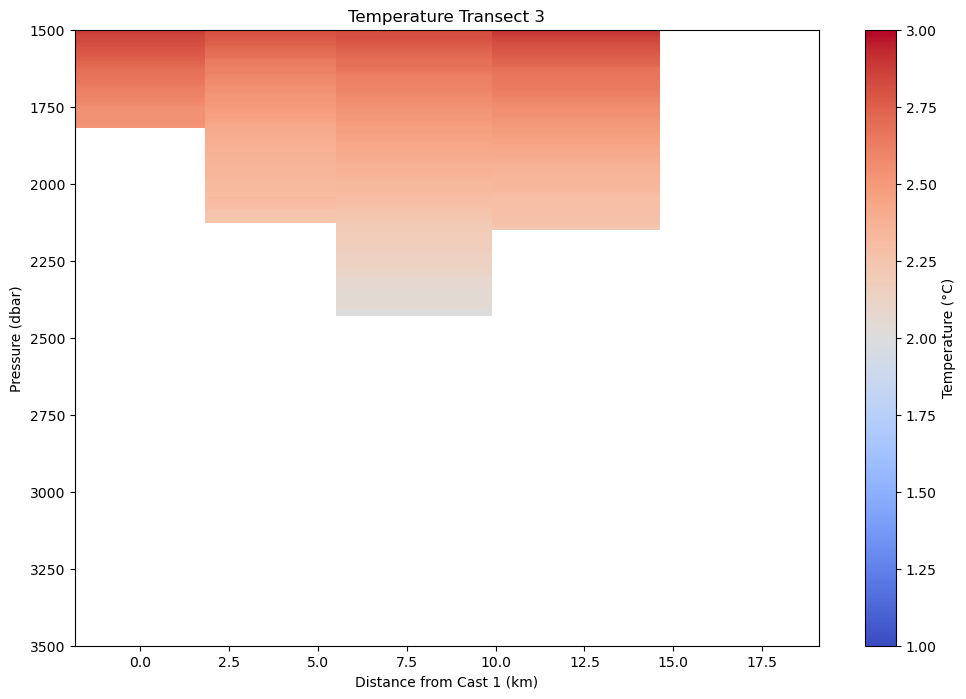

In [12]:
def plot_transect_deep(ds, transect_number):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract the data for plotting
    distance = ds['distance'].values
    pressure = ds['pressure'].values
    temperature = ds['temperature'].values
    
    # Create the meshgrid for distance and pressure
    X, Y = np.meshgrid(distance, pressure)
    
    
    # Plot the temperature as a color mesh
    c = ax.pcolormesh(X, Y, temperature.T, shading='auto', cmap='coolwarm',vmin=1,vmax=3)
    
    # Add color bar
    cb = fig.colorbar(c, ax=ax)
    cb.set_label('Temperature (°C)')
    
    # Set axis labels and title
    ax.set_xlabel('Distance from Cast 1 (km)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title(f'Temperature Transect {transect_number}')
    
    # Reverse the y-axis to have pressure increasing downwards
        # Set color limits for temperature

    
    # Set y-axis limits for pressure
    ax.set_ylim(3500, 1500) 
    
    plt.show()

# Plot the transects
for i, ds in enumerate(transects_datasets):
    plot_transect_deep(ds, i + 1)

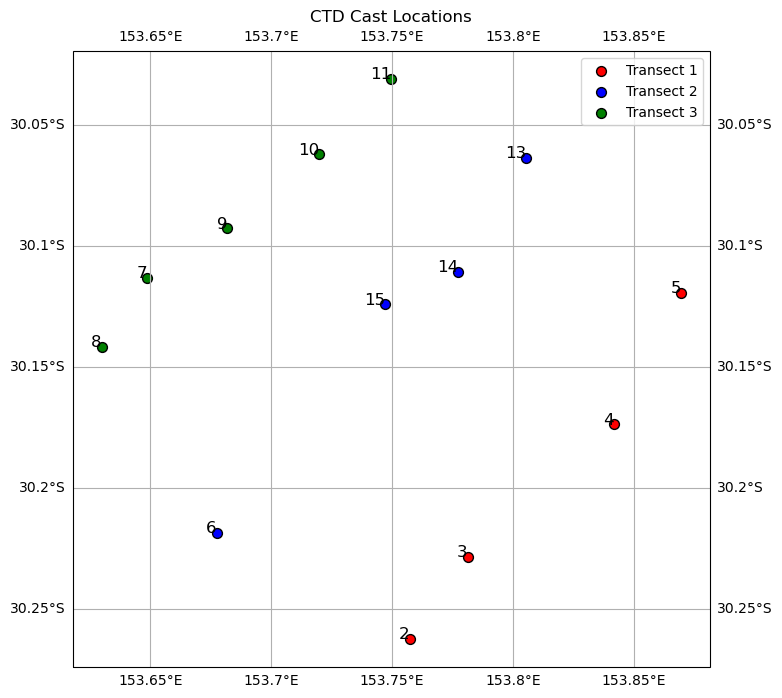

In [56]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='gray',facecolor='gray')

# Add gridlines
ax.gridlines(draw_labels=True)

# Plot the CTD locations for each transect
colors = ['red', 'blue', 'green']

for i, casts in enumerate(transects_casts):
    latitudes = [cast['latitude'] for cast in casts]
    longitudes = [cast['longitude'] for cast in casts]
    ax.scatter(longitudes, latitudes, color=colors[i], edgecolor='black', s=50, label=f'Transect {i+1}')
    for j, (lat, lon) in enumerate(zip(latitudes, longitudes)):
        ax.text(lon, lat, str(transects_indices[i][j]+1), fontsize=12, ha='right')

# Set the title
ax.set_title('CTD Cast Locations')

# Add a legend
plt.legend()

# Show the plot
plt.show()

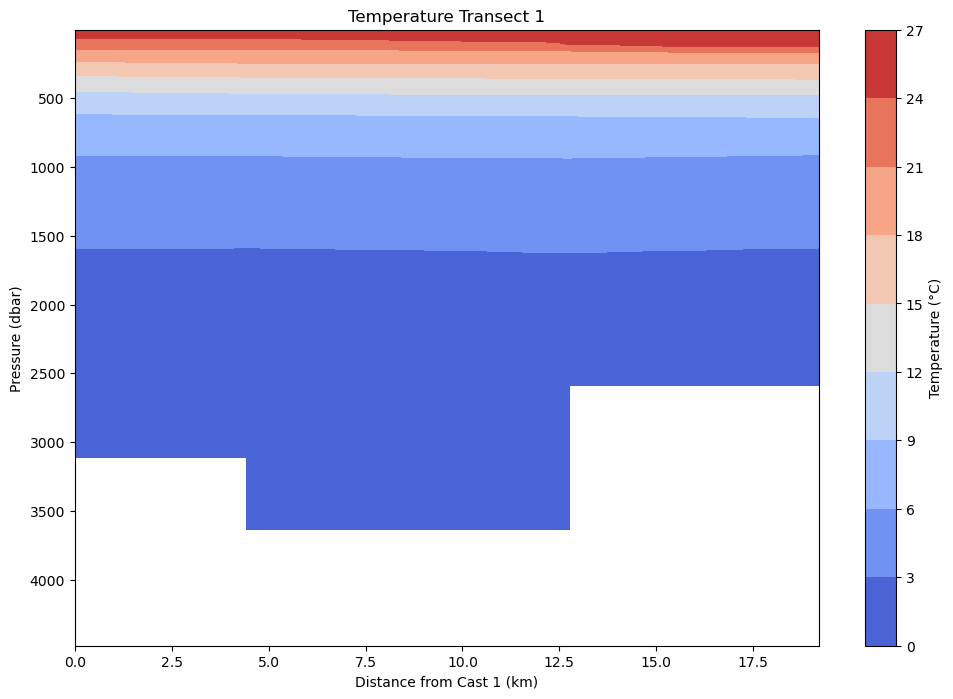

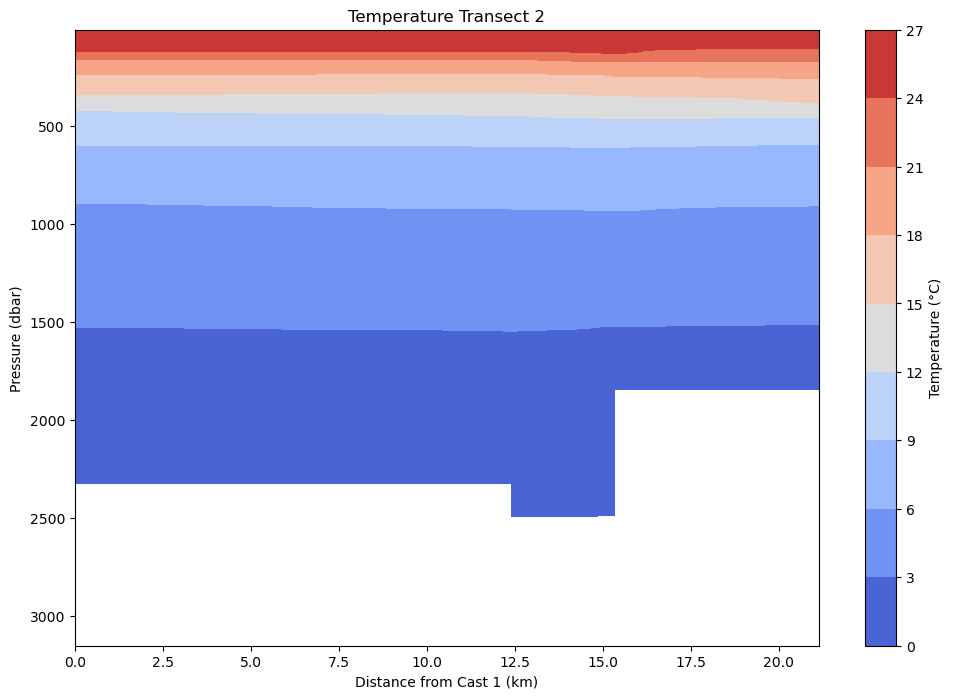

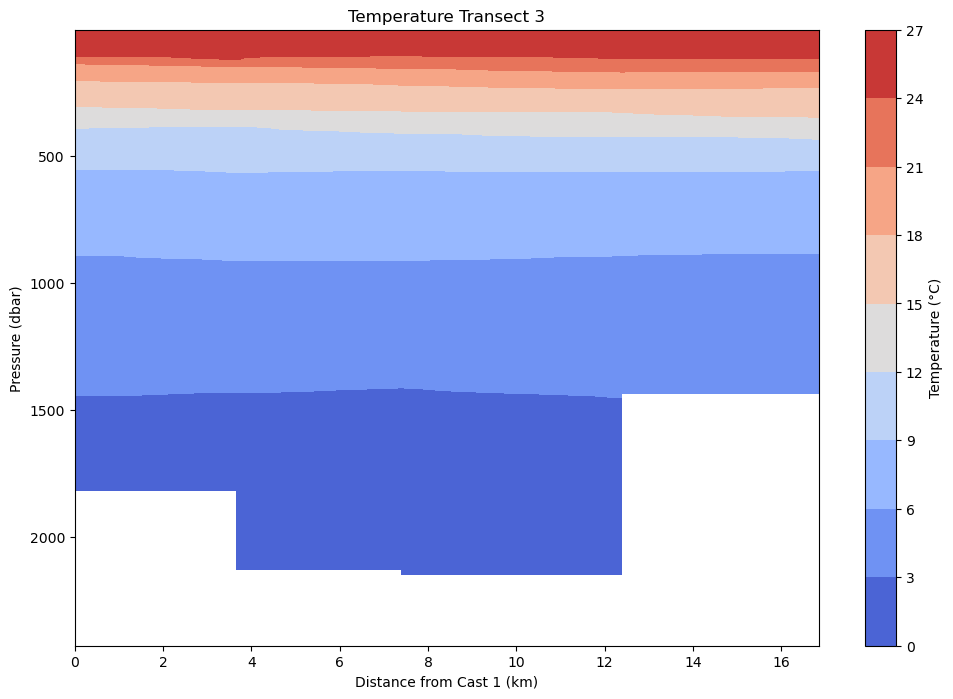

In [3]:
def plot_transect_con(ds, transect_number):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract the data for plotting
    distance = ds['distance'].values
    pressure = ds['pressure'].values
    temperature = ds['temperature'].values
    
    # Create the meshgrid for distance and pressure
    X, Y = np.meshgrid(distance, pressure)
    
    # Plot the temperature as filled contours
    c = ax.contourf(X, Y, temperature.T, cmap='coolwarm')
    
    # Add color bar
    cb = fig.colorbar(c, ax=ax)
    cb.set_label('Temperature (°C)')
    
    # Set axis labels and title
    ax.set_xlabel('Distance from Cast 1 (km)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title(f'Temperature Transect {transect_number}')
    
    # Reverse the y-axis to have pressure increasing downwards
    ax.invert_yaxis()
    
    plt.show()

for i, ds in enumerate(transects_datasets):
    plot_transect_con(ds, i + 1)